# Tree-based Methods (Métodos Baseados em Árvores)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Árvores de Decisão
  * Árvores de Regressão (Regression Trees);
  * Árvores de Classificação (Classification Trees);
  * Classification And Regression Trees (CART)
* Bagging 
* Random Forests
* Boosting


### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 8
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman
  * Capítulos 15, 16


***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

In [2]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import
import pandas as pd
import numpy as np
import seaborn as sns
import pydot
from IPython.display import Image
from six import StringIO  

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error


# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,7)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

### 1. Introdução

Nesta aula, estudaremos os métodos baseados em árvores para modelagem estatística e aprendizado de máquina (Machine Learning), com foco tanto nos aspectos conceituais quanto em aplicações práticas.

Ao final da aula, espera-se que o aluno seja capaz de:

* Compreender o funcionamento de uma árvore de decisão;
* Distinguir entre Árvores de Regressão e Árvores de Classificação;
* Entender o algoritmo CART (Classification and Regression Trees);
* Compreender o conceito de Bagging e como ele contribui para o desempenho dos modelos;
* Entender o funcionamento das Random Forests e suas vantagens em relação às árvores individuais;
* Compreender o conceito de Boosting e sua contribuição para a performance preditiva;
* Explorar o modelo Bayesian Additive Regression Trees (BART) e suas principais características;
* Aplicar os conceitos aprendidos em exemplos práticos utilizando a linguagem Python.

### 2. Decision Trees (Árvores de Decisão)

As árvores de decisão envolvem a estratificação ou segmentação do espaço dos preditores em regiões simples e distintas. Para realizar uma previsão para uma nova observação, normalmente utilizamos a média (em problemas de regressão) ou a moda (em problemas de classificação) das observações de treinamento que pertencem à mesma região.

Como o conjunto de regras de divisão pode ser representado graficamente por uma estrutura hierárquica em forma de árvore, esses métodos são conhecidos como métodos baseados em árvores de decisão.


### 2.1. Árvores de Regressão

Vamos introduzir o conceito de árvores de decisão a partir do caso de regressão, onde o objetivo é prever uma variável contínua. As árvores de regressão são construídas dividindo o espaço dos preditores em regiões homogêneas, onde cada região é associada a uma previsão específica. Nosso caso específico envolve prever o salário de jogadores de beisebol com base em duas características: `Hits` (número de rebatidas) e `Years` (número de anos jogados) - *Predicting Baseball Players’ Salaries Using Regression Trees*.


<div style="text-align:center;">
    <img src="images\Fig_8_1.png"  alt="Imagem" style="width: 650px;"/>
</div>


Nesta sessão, consideraremos o conjunto de dados `Hitters`. Ele consiste em dados individuais de jogadores de beisebol. Em nossas aplicações, estamos interessados ​​em prever os salários dos jogadores - *Salary*.

In [3]:
# Load the data
hitters = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters.csv').dropna()
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


5 linhas × 21 colunas

Em particular, estamos interessados ​​em observar como o número de `Hits` e a anos de experiência (`Years`) preveem o `Salary`. vamos criar uma variável com as variáveis explicativas (features, X) e a variável resposta (target, y):

In [4]:
features = ['Years', 'Hits']
X = hitters[features].values
y = np.log(hitters.Salary.values)

Repare que utilizamos o log(salário), pois ele tem uma distribuição mais gaussiana:

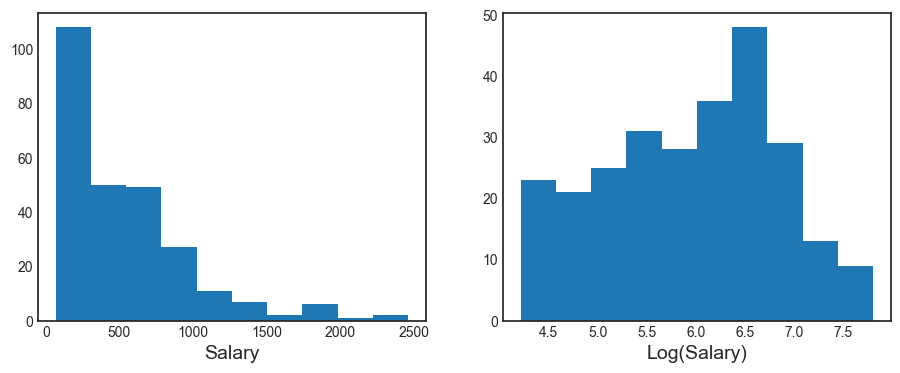

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))

# Plotando a distribuição de salary
ax1.hist(hitters.Salary.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

Para entender o que é uma árvore, vamos primeiro dar uma olhada em uma. 

Vamos ajustar uma regressão com no máximo 3 folhas (3 regiões finais de decisão)

In [6]:
# Ajustando a arvore de decisão com 3 folhas
tree = DecisionTreeRegressor(max_leaf_nodes=3)
# treinando a arvore de decisão
tree.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

Agora, vamos plotar os resultados visualmente. Repare que a maior vantagem das árvores é a interpretabilidade.

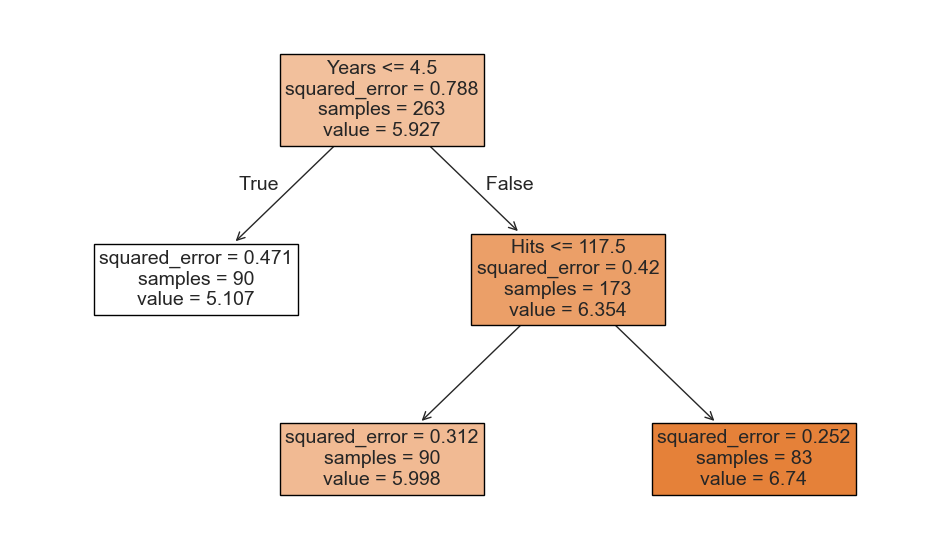

In [7]:
# Figura 8.1
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 8.1');

# Plot tree
plot_tree(tree, filled=True, feature_names=features, fontsize=14, ax=ax);

***Raiz da Árvore***

O primeiro critério de divisão escolhido pelo algoritmo foi a variável Years (anos de experiência).
* A divisão ocorre em dois grupos:
  * Jogadores com Years ≤ 4.5 (ramo esquerdo)
  * Jogadores com Years > 4.5 (ramo direito)
* No nó da raiz, temos:
  * squared_error = 0.788: erro quadrático médio (variância) dos salários dentro do grupo inteiro (antes da divisão).
  * samples = 263: número total de jogadores considerados neste ponto.
  * value = 5.927: média dos salários (em log ou milhares de dólares) de todos os jogadores no conjunto original.

***Ramo Esquerdo (Years ≤ 4.5)***

Como não há divisão adicional, esse nó se torna uma folha.

* Valores:
  * squared_error = 0.471
  * samples = 90
  * value = 5.107: salário médio dos jogadores com até 4,5 anos de experiência.

Isso significa que todas as observações que satisfazem Years ≤ 4.5 caem nessa folha, e recebem a predição de salário igual a 5.107.

***Ramo Direito (Years > 4.5)***

Esse nó passa por uma nova divisão baseada na variável Hits (número de rebatidas):
* Hits ≤ 117.5: ramo esquerdo
* Hits > 117.5: ramo direito
* Valores no nó intermediário:
  * squared_error = 0.42
  * samples = 173
  * value = 6.354: média dos salários entre os jogadores com mais de 4,5 anos de experiência.


***Folha esquerda do nó direito (Hits ≤ 117.5)***

* squared_error = 0.312
* samples = 90
* value = 5.998

Jogadores com mais de 4,5 anos de experiência e menos de 117,5 rebatidas têm salário médio de 5.998.


***Folha direita do nó direito (Hits > 117.5)***

* squared_error = 0.252
* samples = 83
* value = 6.740

Jogadores com mais de 4,5 anos de experiência e mais de 117,5 rebatidas têm salário médio de 6.740.


No geral, ***a árvore estratifica ou segmenta os jogadores*** em três regiões do espaço preditor:

* jogadores que jogaram por quatro anos ou menos
* jogadores que jogaram por cinco ou mais anos e que fizeram menos de 118 rebatidas no ano passado, e
* jogadores que jogaram por cinco anos ou mais e que fizeram pelo menos 118 rebatidas no ano passado.


Essas três regiões podem ser escritas como:

* $R1 = \{X | Years<4,5 \}$
* $R2 = \{X | Years>=4,5, Hits<117,5\}$, e
* $R3 = \{X | Years>=4,5, Hits>=117,5\}$.

Podemos visualizar o espaço e as regiões em um gráfico bidimensional:

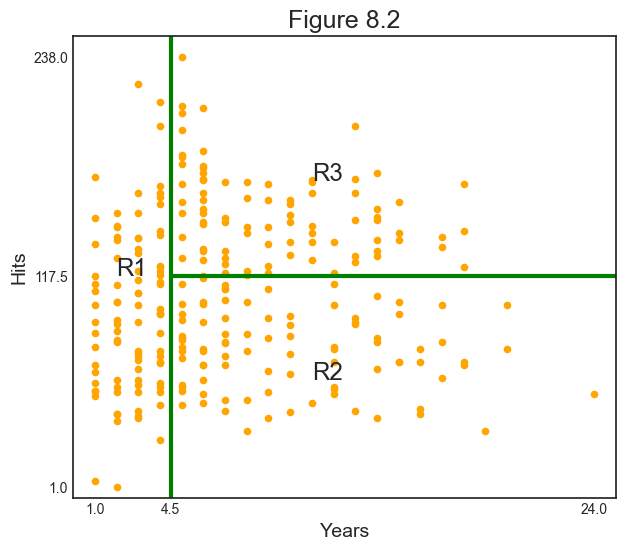

In [8]:
# Figure 8.2
def make_figure_8_2():
    
    # Init
    hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
    plt.title('Figure 8.2')
    plt.xlim(0,25); plt.ylim(ymin=-5);
    plt.xticks([1, 4.5, 24]); plt.yticks([1, 117.5, 238]);

    # Split lines
    plt.vlines(4.5, ymin=-5, ymax=250, color='g')
    plt.hlines(117.5, xmin=4.5, xmax=25, color='g')

    # Regions
    plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
    plt.annotate('R2', xy=(11,60), fontsize='xx-large')
    plt.annotate('R3', xy=(11,170), fontsize='xx-large');

make_figure_8_2()

**Procedimento para construção de uma árvore**

A cada etapa, fazemos:

1. Selecionamos o preditor $X_j$ e o ponto de corte $s$;
2. Dividimos o espaço preditor nas regiões:
   - $R_1(j, s) = \{ X \mid X_j < s \}$
   - $R_2(j, s) = \{ X \mid X_j \geq s \}$

3. Calculamos a **RSS total** após a divisão:

$$
\sum_{i: x_i \in R_1(j, s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j, s)} (y_i - \hat{y}_{R_2})^2
$$

4. Repetimos os passos acima para **todos os preditores** e **todos os possíveis valores de corte $s$**, escolhendo aquele que **minimiza a soma total do erro**:

$$
\arg \min_{j, s} \left\{ \sum_{i: x_i \in R_1(j, s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j, s)} (y_i - \hat{y}_{R_2})^2 \right\}
$$

5. Repetimos esse processo recursivamente, dividindo as regiões formadas, até que alguma **condição de parada** seja atingida (como número mínimo de observações por folha ou profundidade máxima da árvore).


### 2.2. Poda da Árvore de Regressão (Pruning)

O processo de construção de uma árvore de regressão, como vimos anteriormente, pode resultar em uma árvore muito complexa, com várias divisões. Embora essa complexidade permita que o modelo se ajuste muito bem aos dados de treinamento, ela frequentemente leva ao problema conhecido como overfitting (ou sobreajuste). Nesse caso, a árvore "aprende" os ruídos e variações específicas do conjunto de treinamento, perdendo capacidade de generalização.

Em termos estatísticos, uma árvore muito complexa tende a apresentar baixa variância in-sample (no conjunto de treino), mas alta variância out-of-sample (no conjunto de teste), resultando em desempenho preditivo inferior.

Uma estratégia para mitigar esse problema é a ***poda da árvore (pruning)***, que consiste em reduzir o número de divisões (ou folhas) da árvore com o objetivo de diminuir a variância e aumentar a capacidade de generalização.


Podemos ver isso acontecendo se construirmos a mesma árvore acima, mas com 5 folhas.

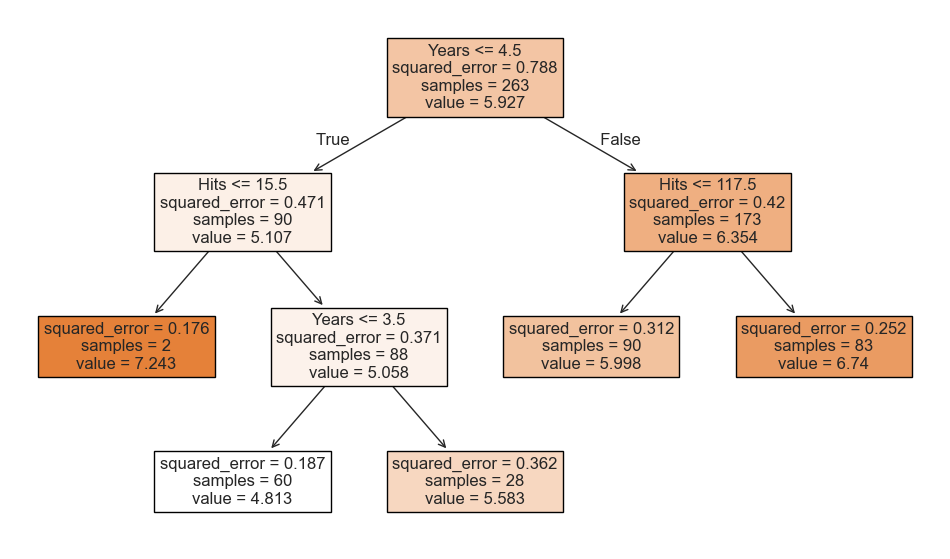

In [22]:
# Compute tree
overfit_tree = DecisionTreeRegressor(max_leaf_nodes=5).fit(X, y)
# Plot tree
fig, ax = plt.subplots(1,1)
plot_tree(overfit_tree, filled=True, feature_names=features, fontsize=12, ax=ax);

Na nova árvore, observamos que a divisão mais à esquerda produz uma previsão de Salary = 7.243 para jogadores com pouca experiência (Years) e poucos Hits. No entanto, essa predição é baseada em apenas 2 observações, o que sugere que provavelmente são outliers. Isso é um claro indício de que a árvore está superajustada ao conjunto de treinamento.

***Restringindo o número mínimo de observações por folha***

Uma maneira de evitar esse tipo de superajuste é exigir que cada folha tenha um número mínimo de observações. Por exemplo, vamos ajustar uma árvore com no máximo 5 folhas, mas exigindo pelo menos 10 observações por folha:

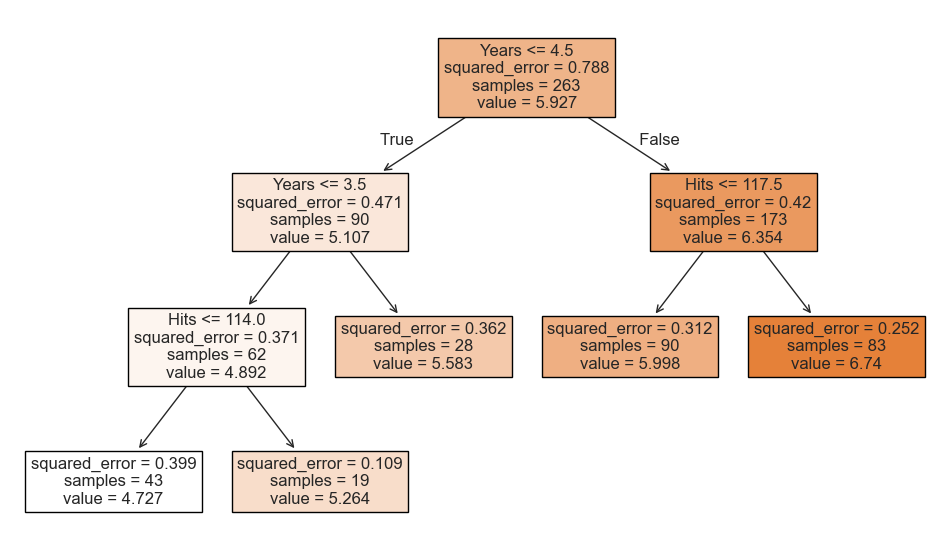

In [24]:
# Compute tree
no_overfit_tree = DecisionTreeRegressor(max_leaf_nodes=5, min_samples_leaf=10).fit(X, y)

# Plot tree
fig, ax = plt.subplots(1,1)
plot_tree(no_overfit_tree, filled=True, feature_names=features, fontsize=12, ax=ax);

Agora, a árvore resultante é mais estável e interpretável:

* Jogadores com menos experiência (Years) e menos rebatidas (Hits) tendem a ter salários mais baixos.
* Essa relação é evidenciada visualmente pelos tons de cor se tornando mais escuros à medida que nos movemos da esquerda (menores salários) para a direita (salários mais altos).

***Outras abordagens para controle da complexidade***

Uma alternativa à imposição de um número mínimo de observações por folha é permitir que a árvore cresça apenas enquanto a redução no RSS (*residual sum of squares*) proporcionada por uma divisão for superior a um determinado limiar. Essa estratégia tende a produzir árvores menores, mas pode ser míope, pois uma divisão pouco informativa no início pode dar origem a subdivisões valiosas posteriormente.


***Escolhendo o tamanho ótimo da árvore: Validação cruzada***

Uma abordagem mais robusta para definir o tamanho ideal da árvore é utilizar validação cruzada, comparando o desempenho preditivo de árvores com diferentes profundidades ou números de folhas. Nas próximas etapas, vamos explorar esse caminho, utilizando dados de treinamento e teste, além de incluir novas variáveis explicativas.

In [27]:
# Import original split
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']
X_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_train.csv').dropna()[features]
X_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_test.csv').dropna()[features]
y_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_train.csv').dropna()
y_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_test.csv').dropna()

Esse código Python abaixo faz uma busca pelo número ideal de folhas (`max_leaf_nodes`) para uma árvore de regressão, utilizando validação cruzada com o objetivo de minimizar o erro de previsão. Ou seja:

* Avaliar o desempenho do modelo `DecisionTreeRegressor` para diferentes tamanhos de árvore (número de folhas de 2 a 10), comparando o erro de:
  * Treinamento
  * Teste
  * Validação cruzada (com 6 folds)
  
Por fim, ele identifica o melhor número de folhas com base no menor erro de validação cruzada.

In [28]:
# Init
params = range(2,11)
reg_scores = np.zeros((len(params),3))
best_score = 10**6

# Loop over all parameters
for i,k in enumerate(params):
    
    # Model
    tree = DecisionTreeRegressor(max_leaf_nodes=k)

    # Loop over splits
    tree.fit(X_train, y_train)
    reg_scores[i,0] = mean_squared_error(tree.predict(X_train), y_train)
    reg_scores[i,1] = mean_squared_error(tree.predict(X_test), y_test)

    # Get CV score
    kf6 = KFold(n_splits=6)
    reg_scores[i,2] = -cross_val_score(tree, X_train, y_train, cv=kf6, scoring='neg_mean_squared_error').mean()
    
    # Save best model
    if reg_scores[i,2]<best_score:
        best_model = tree
        best_score = reg_scores[i,2]

Agora, vamos gerar uma figura com dois gráficos lado a lado para ilustrar visualmente:
* O desempenho dos modelos com diferentes números de folhas (gráfico à esquerda);
* A árvore de decisão que obteve o melhor resultado de validação cruzada (gráfico à direita).

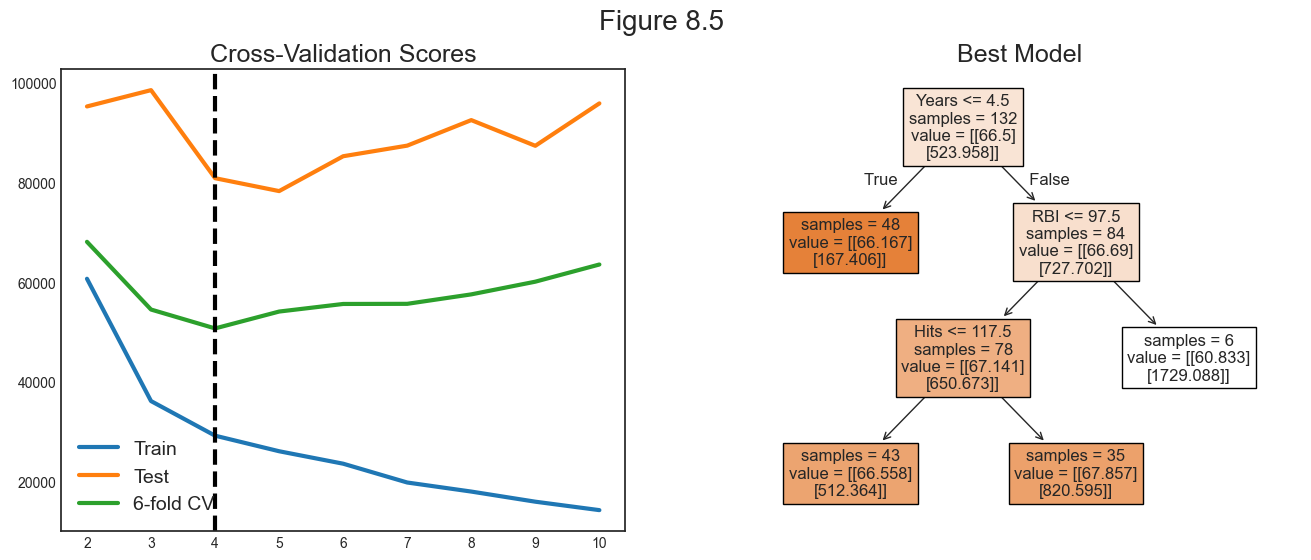

In [71]:
# Figure 8.5
def make_figure_8_5():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    fig.suptitle('Figure 8.5')

    # Plot scores
    ax1.plot(params, reg_scores);
    ax1.axvline(params[np.argmin(reg_scores[:,2])], c='k', ls='--')
    ax1.legend(['Train','Test','6-fold CV']);
    ax1.set_title('Cross-Validation Scores');

    # Plot best tree
    plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);
    ax2.set_title('Best Model');

make_figure_8_5()

O termo Cross-Validation Scores se refere às métricas de erro obtidas durante a validação cruzada de diferentes versões do modelo de árvore de decisão. 

Descrição do gráfico:
* Eixo X → Número de folhas da árvore (max_leaf_nodes) variando de 2 a 10.
* Eixo Y → Erro quadrático médio (quanto menor, melhor).

Interpretação do gráfico:
* O erro de treino (linha azul) diminui continuamente conforme o número de folhas aumenta. Isso é esperado: quanto mais complexa a árvore, melhor ela "memoriza" o conjunto de treinamento.
* O erro de teste (laranja) e o erro de validação cruzada (verde) atingem um mínimo próximo de 4 folhas. Depois disso, começam a subir — sinal de overfitting.
* A linha vertical tracejada preta marca o ponto ótimo escolhido pela validação cruzada (número de folhas que minimiza o erro médio em CV, aqui: 4 folhas).

A árvore à direita representa o modelo vencedor (com 4 folhas), e será usada como preditor final. 

### 2.3. Árvores de Classificação


Uma árvore de classificação é muito semelhante a uma árvore de regressão, exceto que ela é usada para prever uma resposta qualitativa em vez de quantitativa. Para uma árvore de classificação, prevemos que cada observação pertence à classe de observações de treinamento mais comum na região à qual ela pertence.

### Construindo uma Árvore de Classificação

A tarefa de desenvolver uma árvore de **classificação** é bastante semelhante à de desenvolver uma árvore de **regressão**. No entanto, no contexto de classificação, a **Soma dos Quadrados dos Resíduos (RSS)** não pode ser usada como critério para realizar as divisões binárias, pois estamos tentando prever **categorias**, não valores contínuos.

Para isso, usamos medidas de **impureza** que avaliam o quão "puro" um nó é, ou seja, o quanto ele contém observações de uma única classe.

Seja $\hat{p}_{mk}$ a **proporção de observações de treinamento** no **nó $m$** que pertencem à **classe $k$**. Três funções de perda comuns para avaliar divisões são:

#### Taxa de Erro de Classificação

Essa métrica mede a proporção de observações mal classificadas no nó:

$$
E = 1 - \max_k \left( \hat{p}_{mk} \right)
$$


#### Índice de Gini

Muito utilizado por ser mais sensível à heterogeneidade dentro do nó:

$$
G = \sum_{k=1}^{K} \hat{p}_{mk} (1 - \hat{p}_{mk})
$$


#### Entropia (ou Impureza de Shannon)

Vem da teoria da informação, e penaliza fortemente nós com distribuições próximas de uniforme:

$$
D = -\sum_{k=1}^{K} \hat{p}_{mk} \log \hat{p}_{mk}
$$


Em problemas de classificação com **duas classes** (digamos, classe 1 e classe 2), podemos representar a proporção de elementos da **classe 2** em um nó como $\hat{p}$. Abaixo, representamos graficamente como se comportam essas três métricas em função de $\hat{p}$:

- Para $\hat{p} = 0$ ou $\hat{p} = 1$, os nós são **puros**;
- Para $\hat{p} = 0{,}5$, os nós são **máximamente impuros**;
- O índice de Gini e a entropia são **mais sensíveis** a mudanças na distribuição do que a taxa de erro.


### Qual medida usar na prática?

Ao construir uma árvore de classificação, **o índice de Gini** e a **entropia** são mais utilizados para avaliar a qualidade das divisões, pois são mais sensíveis à pureza dos nós do que a taxa de erro de classificação. A taxa de erro costuma ser usada apenas na etapa final, para avaliação do desempenho do classificador.


### Exemplo Prático: Dados de Insuficiência Cardíaca

Nesta seção, vamos trabalhar com o conjunto de dados **Heart**, que contém informações clínicas de pacientes. O objetivo é prever a ocorrência de **doença cardíaca** (variável **HD**), que é **binária**: *Sim* ou *Não*.

Utilizaremos variáveis como idade, pressão arterial, nível de colesterol, entre outras, como preditores.

Nosso objetivo é construir uma árvore de classificação capaz de prever corretamente se um paciente possui ou não histórico de doença cardíaca.


In [72]:
# Load heart dataset
heart = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [73]:
# Fastorize variables
heart.ChestPain = pd.factorize(heart.ChestPain)[0]
heart.Thal = pd.factorize(heart.Thal)[0]

In [74]:
# Set features
features = [col for col in heart.columns if col!='AHD']
X2 = heart[features]
y2 = pd.factorize(heart.AHD)[0]

Agora ajustamos nosso classificador.

In [75]:
# Fit classification tree
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=11)
clf.fit(X2,y2)

DecisionTreeClassifier(max_leaf_nodes=11)

Qual é a pontuação?

In [76]:
# Final score
clf.score(X2,y2)

0.8686868686868687

Vamos dar uma olhada na árvore inteira.

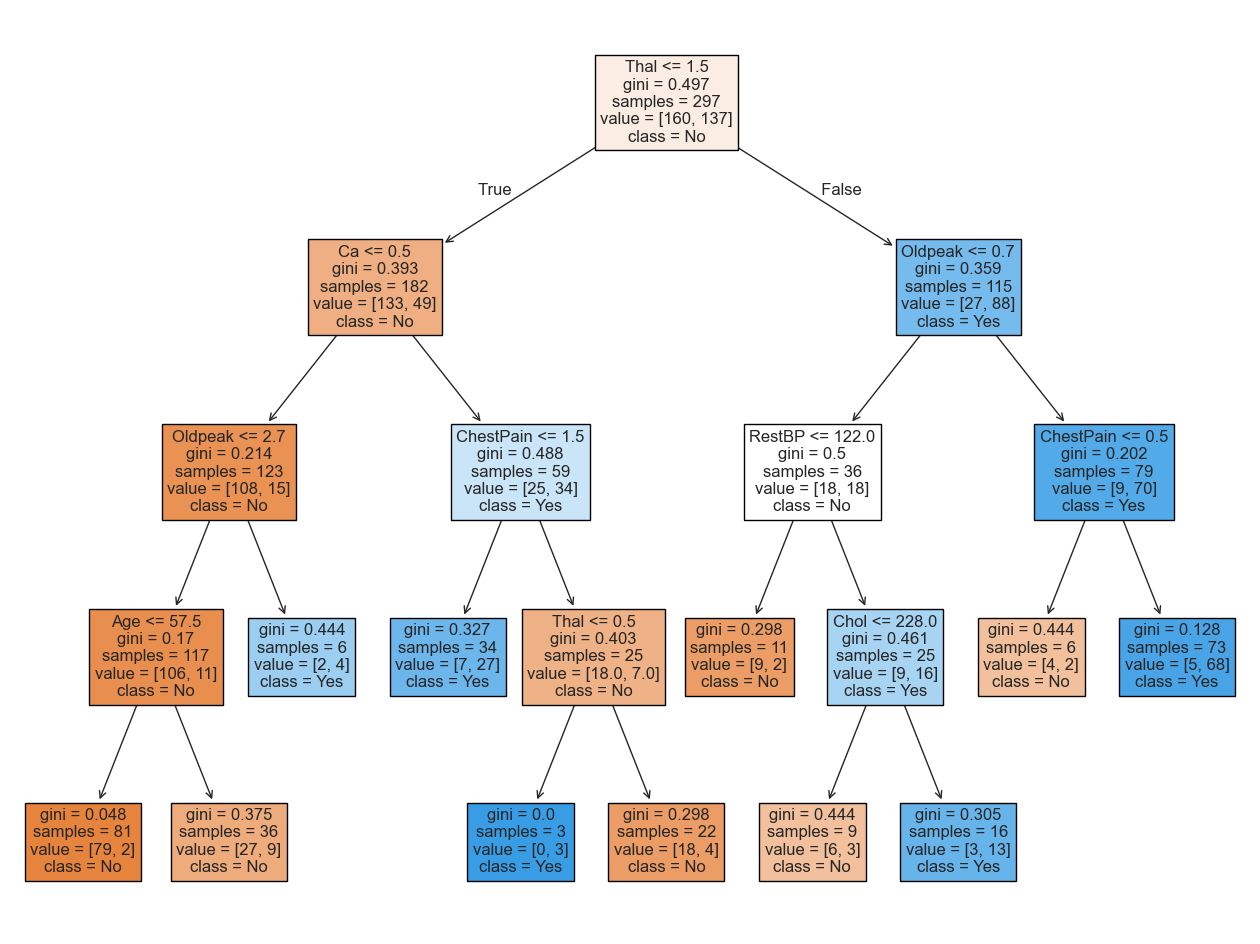

In [ ]:
# Figure 8.6 a
def make_fig_8_6a():
    
    # Init
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    ax.set_title('Figure 8.6');

    # Plot tree
    plot_tree(clf, filled=True, feature_names=features, class_names=['No','Yes'], fontsize=12, ax=ax);

make_fig_8_6a()    

Esta figura tem uma característica surpreendente: algumas das divisões produzem dois nós terminais que têm o mesmo valor previsto.

Por exemplo, considere a divisão Age<=57,5 próxima ao canto inferior esquerdo da árvore não podada. Independentemente do valor de Age, um valor de resposta de Não é previsto para essas observações. Por que, então, a divisão é realizada?

A divisão é realizada porque leva ao aumento da pureza do nó. Ou seja, 2/81 das observações correspondentes à folha da esquerda têm um valor de resposta de Sim , enquanto 9/36 daquelas correspondentes à folha da direita têm um valor de resposta de Sim . Por que a pureza do nó é importante? Suponha que temos uma observação de teste que pertence à região dada por essa folha da esquerda. Então podemos ter quase certeza de que seu valor de resposta é Não . Em contraste, se uma observação de teste pertence à região dada pela folha da direita, então seu valor de resposta é provavelmente Não , mas temos muito menos certeza. Mesmo que a divisão Age<=57,5 não reduza o erro de classificação, ela melhora o índice de Gini e a entropia, que são mais sensíveis à pureza do nó.

### 2.4. Poda para Àrvore de Classificação (Pruning)

Podemos repetir o exercício de poda também para a tarefa de classificação.

In [78]:
# Figure 8.6 b
def make_figure_8_6b():
    
    # Init
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle('Figure 8.6')

    # Plot scores
    ax1.plot(params, clf_scores);
    ax1.legend(['Train','Test','6-fold CV']);

    # Plot best tree
    plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);

In [79]:
# Init
J = 10
params = range(2,11)
clf_scores = np.zeros((len(params),3))
best_score = 100

# Loop over all parameters
for i,k in enumerate(params):
    
    # Model
    tree = DecisionTreeClassifier(max_leaf_nodes=k)
    
    # Loop J times
    temp_scores = np.zeros((J,3))
    for j in range (J):

        # Loop over splits
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        m = tree.fit(X2_train, y2_train)
        temp_scores[j,0] = mean_squared_error(m.predict(X2_train), y2_train)
        temp_scores[j,1] = mean_squared_error(m.predict(X2_test), y2_test)

        # Get CV score
        kf6 = KFold(n_splits=6)
        temp_scores[j,2] = -cross_val_score(tree, X2_train, y2_train, cv=kf6, scoring='neg_mean_squared_error').mean()
        
        # Save best model
        if temp_scores[j,2]<best_score:
            best_model = m
            best_score = temp_scores[j,2]
        
    # Average
    clf_scores[i,:] = np.mean(temp_scores, axis=0)

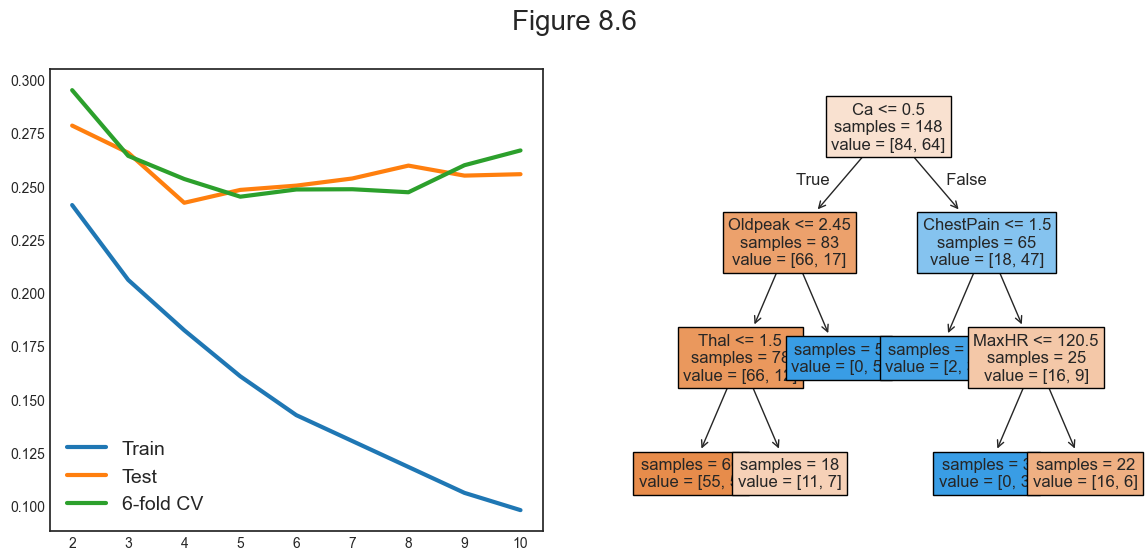

In [80]:
make_figure_8_6b()

Outras questões
Valores preditivos ausentes
Geralmente há duas maneiras principais de lidar com valores ausentes:

descartar as observações
preencha os valores ausentes com previsões usando as outras observações (por exemplo, média)
Com árvores podemos fazer melhor:

codificá-los como uma classe separada (por exemplo, 'ausente')
gerar divisões usando dados não ausentes e usar variáveis ​​não ausentes em dados ausentes para imitar as divisões com dados ausentes
Preditores Categóricos
Ao dividir um preditor com q valores possíveis não ordenados, há
possíveis partições dos valores q em dois grupos, e os cálculos tornam-se proibitivos para grandes
. No entanto, com um
resultado, esse cálculo simplifica.

Divisões de Combinação Linear
Em vez de restringir as divisões para serem do tipo
, pode-se permitir divisões ao longo de combinações lineares da forma
. Os pesos
tornar-se parte do procedimento de otimização.

Outros procedimentos de construção de árvores
O procedimento que vimos para construir árvores é chamado CART (Árvore de Classificação e Regressão). Existem outros procedimentos.

A Matriz de Perdas
Em relação a outros métodos, a escolha das funções de perda desempenha um papel muito mais importante.

Divisões binárias
Você pode fazer divisões não binárias, mas no final elas são apenas versões mais fracas das divisões binárias.

Instabilidade
As árvores têm uma variância muito alta .

Dificuldade em capturar a estrutura aditiva
Árvores são muito ruins em modelar estruturas aditivas.

Falta de suavidade
As árvores não são lisas.

Árvores vs Regressão
Vantagens

Árvores são muito fáceis de explicar às pessoas. Aliás, são ainda mais fáceis de explicar do que a regressão linear!
Algumas pessoas acreditam que as árvores de decisão refletem mais de perto a tomada de decisão humana do que as abordagens de regressão e classificação vistas nos capítulos anteriores.
As árvores podem ser exibidas graficamente e são facilmente interpretadas até mesmo por um não especialista (especialmente se forem pequenas).
As árvores podem manipular facilmente preditores qualitativos sem a necessidade de criar variáveis ​​fictícias.
Desvantagens

árvores geralmente não têm o mesmo nível de precisão preditiva que algumas das outras abordagens de regressão e classificação vistas neste livro.
Árvores podem ser muito pouco robustas. Em outras palavras, uma pequena alteração nos dados pode causar uma grande alteração na árvore estimada final.

### 7 Bagging, Florestas Aleatórias, Boosting


Bagging, florestas aleatórias e boosting usam árvores como blocos de construção para construir modelos de previsão mais poderosos.

Ensacamento
O principal problema das árvores de decisão é que elas sofrem com alta variância . A agregação bootstrap , ou bagging , é um procedimento de uso geral para reduzir a variância de um método de aprendizado estatístico.

A ideia principal por trás do bagging é que, dado um conjunto de n observações independentes
, cada um com variância
, a variância da média
das observações é dado por
. Em outras palavras, calcular a média de um conjunto de observações reduz a variância.

De fato, o bagging consiste em pegar muitos conjuntos de treinamento da população, construir um modelo de previsão separado usando cada conjunto de treinamento e calcular a média das previsões resultantes . Como não temos acesso a muitos conjuntos de treinamento, recorremos ao bootstrapping.

Estimativa de erro fora da sacola
Acontece que existe uma maneira muito simples de estimar o erro de teste de um modelo ensacado, sem a necessidade de realizar validação cruzada ou a abordagem do conjunto de validação. Lembre-se de que a chave para o ensaque é que as árvores são repetidamente ajustadas a subconjuntos bootstrapped das observações. Pode-se mostrar que, em média, cada árvore ensacada utiliza cerca de dois terços das observações. O terço restante das observações não utilizadas para ajustar uma determinada árvore ensacada são chamadas de observações fora do ensaque (OOB). Podemos prever a resposta para a i-ésima observação usando cada uma das árvores nas quais essa observação foi OOB.

Agora vamos calcular o índice de Gini para o Heartconjunto de dados usando diferentes números de árvores.

In [81]:
# Init (takes a lot of time with J=30)
params = range(2,50)
bagging_scores = np.zeros((len(params),2))
J = 30;

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        bagging = BaggingClassifier(DecisionTreeClassifier(), max_samples=k, oob_score=True)
        bagging.fit(X2_train,y2_train)
        temp_scores[j,0] = bagging.score(X2_test, y2_test)
        temp_scores[j,1] = bagging.oob_score_
        
    # Average
    bagging_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

Vamos traçar o erro Out-of-Bag calculado durante a geração do estimador ensacado.

In [83]:
# Make new figure 1
def make_new_figure_1():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle("Estimated $R^2$")

    # Plot scores
    ax.plot(params, bagging_scores);
    ax.legend(['Test','OOB']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('R^2');

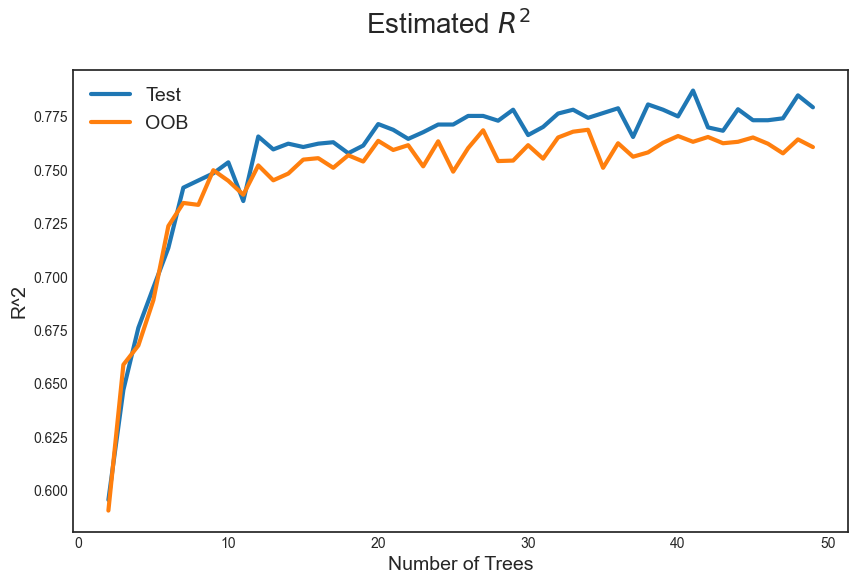

In [84]:
make_new_figure_1()

Pode-se demonstrar que, com B suficientemente grande, o erro OOB é virtualmente equivalente ao erro de validação cruzada "leave-one-out". A abordagem OOB para estimar o erro de teste é particularmente conveniente ao realizar bagging em grandes conjuntos de dados para os quais a validação cruzada seria computacionalmente onerosa.

### Medidas de Importância Variável

Como discutimos, a principal vantagem do bagging é reduzir a variância da previsão. No entanto, com o bagging, pode ser difícil interpretar o modelo resultante. Na verdade, não podemos mais desenhar árvores, pois temos muitas delas.

No entanto, é possível obter um resumo geral da importância de cada preditor usando o RSS (para árvores de regressão bagging) ou o índice de Gini (para árvores de classificação bagging). No caso de árvores de regressão bagging, podemos registrar a quantidade total de redução do RSS devido a divisões em um determinado preditor, calculada a média de todas as árvores. Um valor alto indica um preditor importante. Da mesma forma, no contexto de árvores de classificação bagging, podemos somar a quantidade total de redução do índice de Gini devido a divisões em um determinado preditor, calculada a média de todas as árvores.

In [85]:
# Compute feature importance
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)

Podemos dar uma olhada na importância de cada característica.

In [86]:
# Figure 8.9
def make_figure_8_9():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    ax.set_title('Figure 8.9: Feature Importance');

    # Plot feature importance
    h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
    h1 = h1.sort_values(by='Importance', axis=0, ascending=False)
    h1.plot(kind='barh', color='r', ax=ax)
    ax.set_xlabel('Variable Importance'); 
    plt.yticks(fontsize=14);
    plt.gca().legend_ = None;

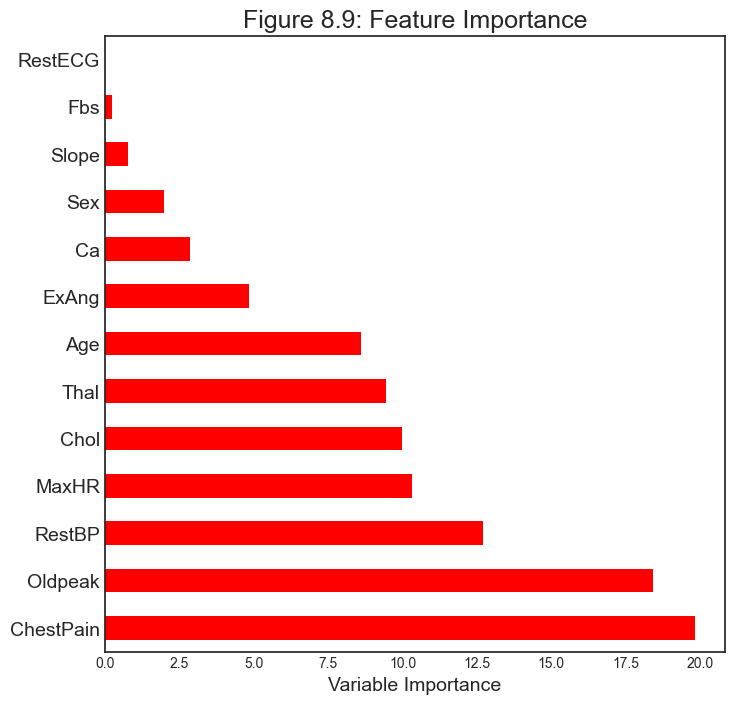

In [87]:
make_figure_8_9()

### Florestas aleatórias


Florestas aleatórias oferecem uma melhoria em relação às árvores ensacadas por meio de um pequeno ajuste que as descorrelaciona . Assim como no ensacamento, construímos uma série de árvores de decisão em amostras de treinamento bootstrapped. Mas, ao construir essas árvores de decisão, cada vez que uma divisão em uma árvore é considerada, uma amostra aleatória de
preditores são escolhidos como candidatos divididos do conjunto completo de
preditores. A divisão pode usar apenas um desses m preditores. Uma nova amostra de
os preditores são obtidos em cada divisão e, normalmente, escolhemos
— isto é, o número de preditores considerados em cada divisão é aproximadamente igual à raiz quadrada do número total de preditores

Em outras palavras, ao construir uma floresta aleatória, em cada divisão na árvore, o algoritmo não tem permissão nem para considerar a maioria dos preditores disponíveis. Isso pode parecer loucura, mas tem uma justificativa inteligente. Suponha que haja um preditor muito forte no conjunto de dados, juntamente com vários outros preditores moderadamente fortes. Então, na coleção de árvores ensacadas, a maioria ou todas as árvores usarão esse preditor forte na divisão superior. Consequentemente, todas as árvores ensacadas parecerão bastante semelhantes entre si. Portanto, as previsões das árvores ensacadas serão altamente correlacionadas. Infelizmente, a média de muitas quantidades altamente correlacionadas não leva a uma redução tão grande na variância quanto a média de muitas quantidades não correlacionadas. Em particular, isso significa que o ensacamento não levará a uma redução substancial na variância em uma única árvore nesse cenário.

Florestas aleatórias superam esse problema forçando cada divisão a considerar apenas um subconjunto dos preditores .

Vamos dividir os dados em 2 e calcular o teste e a estimativa
, tanto para florestas quanto para árvores.

In [88]:
import warnings
warnings.simplefilter('ignore')

# Init (takes a lot of time with J=30)
params = range(2,50)
forest_scores = np.zeros((len(params),2))
J = 30

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        forest = RandomForestClassifier(n_estimators=k, oob_score=True, max_features="sqrt")
        forest.fit(X2_train,y2_train)
        temp_scores[j,0] = forest.score(X2_test, y2_test)
        temp_scores[j,1] = forest.oob_score_
        
    # Average
    forest_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

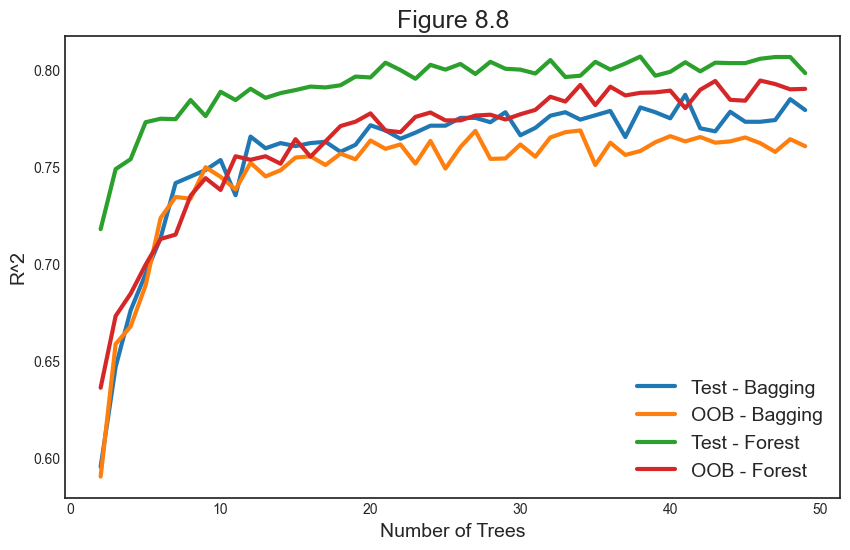

In [89]:
# Figure 8.8
def make_figure_8_8():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.set_title('Figure 8.8');

    # Plot scores
    ax.plot(params, bagging_scores);
    ax.plot(params, forest_scores);
    ax.legend(['Test - Bagging','OOB - Bagging', 'Test - Forest','OOB - Forest']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('R^2');

make_figure_8_8()

Quanto ao ensacamento, podemos traçar a importância do recurso.

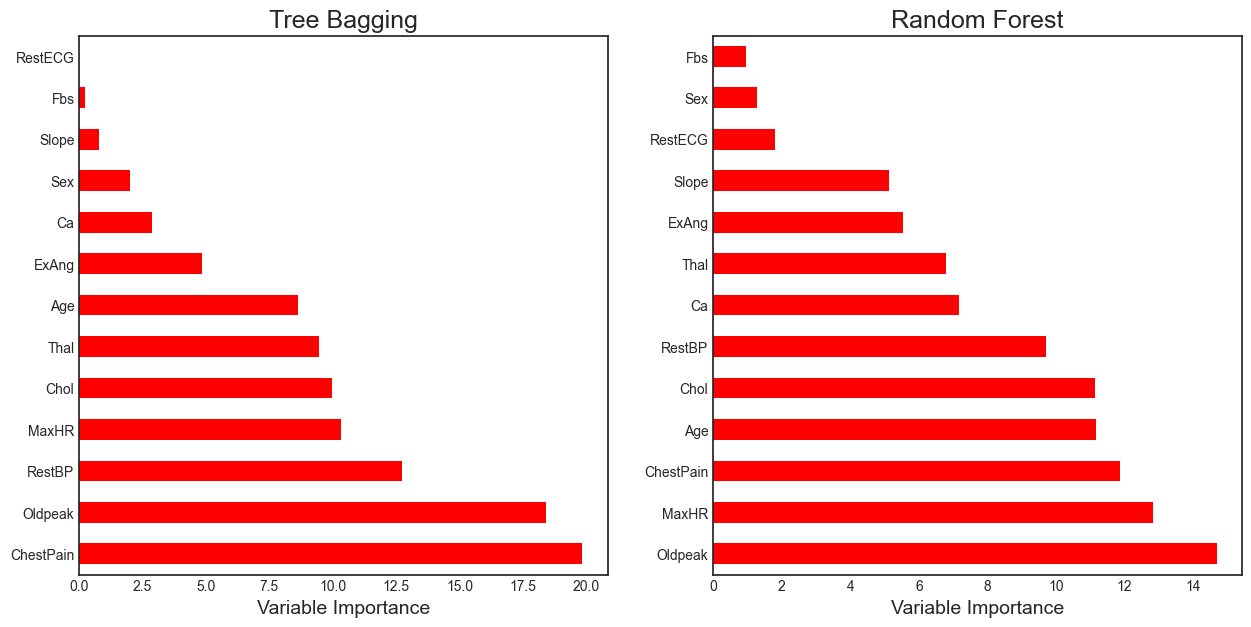

In [90]:
# Make new figure 2
def make_new_figure_2():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

    # Plot feature importance - Bagging
    h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
    h1 = h1.sort_values(by='Importance', axis=0, ascending=False)
    h1.plot(kind='barh', color='r', ax=ax1)
    ax1.set_xlabel('Variable Importance'); 
    ax1.set_title('Tree Bagging')

    # Plot feature importance
    h2 = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=features)
    h2 = h2.sort_values(by='Importance', axis=0, ascending=False)
    h2.plot(kind='barh', color='r', ax=ax2)
    ax2.set_title('Random Forest')

    # All plots
    for ax in fig.axes:
        ax.set_xlabel('Variable Importance'); 
        ax.legend([])

make_new_figure_2()

Na figura, observamos que a classificação de importância das variáveis ​​é semelhante à do bagging e das florestas aleatórias, mas há diferenças significativas.

Agora, vamos analisar a importância das florestas aleatórias usando o Khanconjunto de dados genéticos. Este conjunto de dados tem a peculiaridade de possuir um grande número de características e pouquíssimas observações.

In [114]:
# Load data
gene = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Khan.csv')
print(len(gene))
gene.head()

83


,x,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V2299,V2300,V2301,V2302,V2303,V2304,V2305,V2306,V2307,V2308
0,2,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,...,-0.238511,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172
1,2,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,...,-0.657394,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395
2,2,-0.084469,-1.649739,-0.241308,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,...,-0.696352,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434
3,2,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,...,0.259746,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483
4,2,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,...,-0.200404,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966


5 linhas × 2309 colunas

O conjunto de dados tem 83 linhas e 2309 colunas.

Como é um conjunto de dados muito amplo , selecionar os recursos corretos é crucial.

Observe também que não podemos executar regressão linear neste conjunto de dados.

In [115]:
# Reduce dataset size
gene_small = gene.iloc[:,0:202]
X = gene_small.iloc[:,1:]
y = gene_small.iloc[:,0]

Vamos agora fazer uma validação cruzada sobre o número de árvores e o número máximo de recursos considerados.

In [116]:
# Init (takes a lot of time with J=30)
params = range(50,150,10)
m_scores = np.zeros((len(params),3))
p = np.shape(X)[1]
J = 30;

# Loop over parameters
for i, k in enumerate(params):
    
    # Array of features
    ms = [round(p/2), round(np.sqrt(p)), round(np.log(p))]
    
    # Repeat L times
    temp_scores = np.zeros((J,3))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
    
        # Loop over values of m
        for index, m in enumerate(ms):
            forest = RandomForestClassifier(n_estimators=k, max_features=m, oob_score=True)
            forest.fit(X, y)
            temp_scores[j,index] = forest.oob_score_
        print("", end="\r")
            
    # Average
    m_scores[i,:] = np.mean(temp_scores, axis=0)

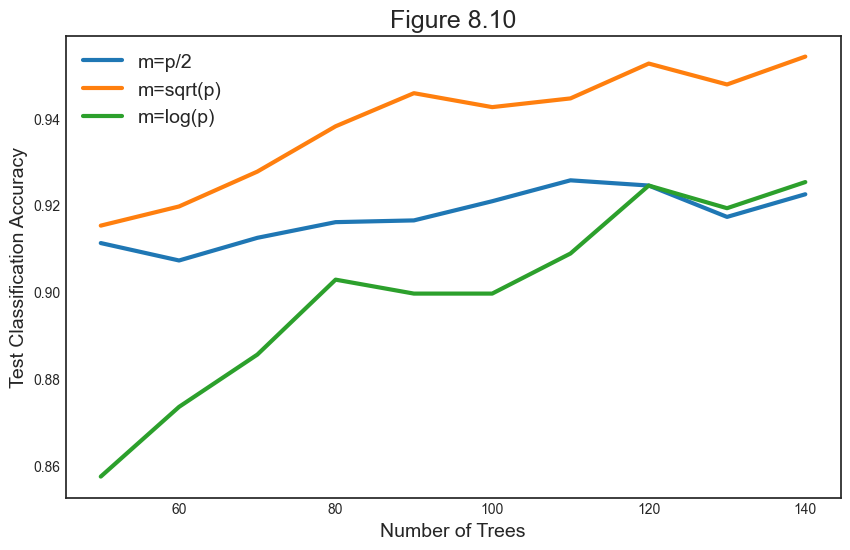

In [94]:
# Figure 8.10
def make_figure_8_10():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.set_title('Figure 8.10');

    # Plot scores
    ax.plot(params, m_scores);
    ax.legend(['m=p/2','m=sqrt(p)','m=log(p)']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

make_figure_8_10()

Parece que as melhores pontuações são alcançadas com poucos recursos e muitas árvores.

### Boosting (Impulsionando)

Assim como o bagging, o boosting é uma abordagem geral que pode ser aplicada a muitos métodos de aprendizado estatístico para regressão ou classificação. Aqui, restringimos nossa discussão sobre boosting ao contexto de árvores de decisão.

O boosting funciona de forma semelhante ao bagging, exceto que as árvores são cultivadas sequencialmente: cada árvore é cultivada usando informações de árvores cultivadas anteriormente. O boosting não envolve amostragem bootstrap; em vez disso, cada árvore é ajustada a uma versão modificada do conjunto de dados original.

Qual é a ideia por trás desse procedimento? Dado o modelo atual, ajustamos uma árvore de decisão aos resíduos do modelo. Ou seja, ajustamos uma árvore usando os resíduos atuais , em vez do resultado.
, como a resposta. Em seguida, adicionamos essa nova árvore de decisão à função ajustada para atualizar os resíduos. Cada uma dessas árvores pode ser bastante pequena, com apenas alguns nós terminais, determinados pelo parâmetro
no algoritmo. Ajustando pequenas árvores aos resíduos, melhoramos lentamente
em áreas onde não apresenta bom desempenho . O parâmetro de encolhimento λ retarda ainda mais o processo, permitindo que mais árvores, com formatos diferentes, ataquem os resíduos. Em geral, abordagens de aprendizado estatístico que aprendem lentamente tendem a apresentar bom desempenho.

Algoritmo
O algoritmo de reforço funciona da seguinte maneira:

Definir
e
para todos
no conjunto de treinamento.

Para
repita:

a. Encaixe uma árvore
com
divisões (
nós terminais) para os dados de treinamento
.

b. Atualização
adicionando uma versão reduzida da nova árvore:

c. Atualizar os resíduos

Saída do modelo impulsionado

O Boosting tem três parâmetros de ajuste:

O número de árvores 
O parâmetro de encolhimento 
. Isso controla a taxa de aprendizado do boosting.
O número de divisões em cada árvore 
, que controla a complexidade do conjunto reforçado. Frequentemente, d = 1 funciona bem, caso em que cada árvore é um toco, consistindo em uma única divisão.

In [95]:
# Init , oob_score=True
params = range(50,150,10)
boost_scores = np.zeros((len(params),3))
p = np.shape(X)[1]
J = 30

# Loop over parameters
for i, k in enumerate(params):
    
    # Repeat L times
    temp_scores = np.zeros((J,3))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=j)
    
        # First score: random forest
        forest = RandomForestClassifier(n_estimators=k, max_features="sqrt")
        forest.fit(X_train, y_train)
        temp_scores[j,0] = forest.score(X_test, y_test)

        # Second score: boosting with 1-split trees
        boost1 = GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=k, max_features="sqrt")
        boost1.fit(X_train, y_train)
        temp_scores[j,1] = boost1.score(X_test, y_test)

        # Third score: boosting with 1-split trees
        boost2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=k, max_features="sqrt")
        boost2.fit(X_train, y_train)
        temp_scores[j,2] = boost2.score(X_test, y_test)
        print("", end="\r")
    
    # Average
    boost_scores[i,:] = np.mean(temp_scores, axis=0)

Vamos comparar boosting e floresta.

In [ ]:
# Figure 8.11
def make_figure_8_11():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.set_title('Figure 8.11');

    # Plot scores
    ax.plot(params, m_scores);
    ax.legend(['forest','boosting with d=1','boosting with d=2']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

make_figure_8_11()

### Aplicando Random Forests e Boosting

Vamos aplicar Random Forests, Boosting e Bagging ao conjunto de dados Heart com os pacotes `sklearn` e `xgboost` do Python. Vamos comparar o desempenho de cada método usando validação cruzada.
```


In [112]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Definindo o classificador de árvore de decisão
    # OBS: Em muitos problemas de classificação, valores entre 3 e 10 são um bom ponto de partida.
    # Em Random Forests, árvores são geralmente não podadas (crescem até separar completamente os dados), porque o ensemble corrige o overfitting individual.
tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(max_depth=2, random_state=42)

# Definindo o classificador de Random Forest
    # n_estimators=100: Significa que serão construídas 100 árvores de decisão.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Definindo o classificador de Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Definindo o classificador de Bagging (corrigido)
bag_clf1 = BaggingClassifier(estimator=tree_clf1, n_estimators=100, random_state=42)
bag_clf2 = BaggingClassifier(estimator=tree_clf2, n_estimators=100, random_state=42)

# Avaliando o desempenho de cada classificador usando validação cruzada
scores_rf = cross_val_score(rf_clf, X, y, cv=5)
scores_gb = cross_val_score(gb_clf, X, y, cv=5)
scores_bag1 = cross_val_score(bag_clf1, X, y, cv=5)
scores_bag2 = cross_val_score(bag_clf2, X, y, cv=5)

# Exibindo os resultados
print("Random Forests Accuracy: {:.2f} ± {:.2f}".format(scores_rf.mean(), scores_rf.std()))
print("Boosting Accuracy: {:.2f} ± {:.2f}".format(scores_gb.mean(), scores_gb.std()))
print("Bagging Accuracy: {:.2f} ± {:.2f}".format(scores_bag1.mean(), scores_bag1.std()))
print("Bagging with Pruned Trees Accuracy: {:.2f} ± {:.2f}".format(scores_bag2.mean(), scores_bag2.std()))


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py", line 421, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py", line 831, in _validate_y_class_weight
    check_classification_targets(y)
  File "c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\multiclass.py", line 219, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


***Aplicação para Regressão***

In [117]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Regressão com Decision Trees
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Boosting
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Bagging
bag_reg1 = BaggingRegressor(estimator=tree_reg1, n_estimators=100, random_state=42)
bag_reg2 = BaggingRegressor(estimator=tree_reg2, n_estimators=100, random_state=42)

# Avaliação com base no MSE
def evaluate_model(model, X, y):
    neg_mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -neg_mse_scores  # transformando em MSE positivo
    return mse_scores.mean(), mse_scores.std()

# Avaliando todos os modelos
mse_rf, std_rf = evaluate_model(rf_reg, X, y)
mse_gb, std_gb = evaluate_model(gb_reg, X, y)
mse_bag1, std_bag1 = evaluate_model(bag_reg1, X, y)
mse_bag2, std_bag2 = evaluate_model(bag_reg2, X, y)

# Exibindo os resultados
print("Random Forest MSE: {:.4f} ± {:.4f}".format(mse_rf, std_rf))
print("Boosting MSE: {:.4f} ± {:.4f}".format(mse_gb, std_gb))
print("Bagging MSE: {:.4f} ± {:.4f}".format(mse_bag1, std_bag1))
print("Bagging (Pruned Trees) MSE: {:.4f} ± {:.4f}".format(mse_bag2, std_bag2))


Random Forest MSE: 0.3284 ± 0.2005
Boosting MSE: 0.4738 ± 0.3342
Bagging MSE: 0.3290 ± 0.1958
Bagging (Pruned Trees) MSE: 0.3624 ± 0.1973


Random Forest apresentou o menor erro médio quadrático (MSE), embora o Bagging com árvore não podada tenha desempenho muito próximo.

Boosting teve o pior desempenho nesse caso (maior MSE e desvio padrão).

***Outros Modelos baseados em árvores (mais avançados)***

* XGBoost (xgboost): Gradient Boosting otimizado com regularização L1/L2.
  * Extremamente rápido e preciso.
  * Venceu várias competições do Kaggle.

* LightGBM (lightgbm): Versão otimizada de boosting da Microsoft.
  * Mais rápido que XGBoost em grandes datasets.
  * Usa histogramas para acelerar os splits.

* CatBoost (catboost)
  * Desenvolvido pela Yandex.
  * Ótimo para dados com variáveis categóricas.
  * Muito eficiente e geralmente requer menos pré-processamento.



In [121]:
# Instalação dos pacotes (execute no terminal ou notebook se ainda não tiver)
# !pip install xgboost lightgbm catboost

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Modelos externos
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Regressão com Decision Trees
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Gradient Boosting tradicional
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Bagging
bag_reg1 = BaggingRegressor(estimator=tree_reg1, n_estimators=100, random_state=42)
bag_reg2 = BaggingRegressor(estimator=tree_reg2, n_estimators=100, random_state=42)

# XGBoost
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbosity=0)

# LightGBM
lgbm_reg = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# CatBoost
cat_reg = CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)

# Avaliação com base no MSE
def evaluate_model(model, X, y):
    neg_mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -neg_mse_scores  # transformando em MSE positivo
    return mse_scores.mean(), mse_scores.std()

# Avaliando todos os modelos
mse_rf, std_rf = evaluate_model(rf_reg, X, y)
mse_gb, std_gb = evaluate_model(gb_reg, X, y)
mse_bag1, std_bag1 = evaluate_model(bag_reg1, X, y)
mse_bag2, std_bag2 = evaluate_model(bag_reg2, X, y)
mse_xgb, std_xgb = evaluate_model(xgb_reg, X, y)
mse_lgbm, std_lgbm = evaluate_model(lgbm_reg, X, y)
mse_cat, std_cat = evaluate_model(cat_reg, X, y)

# Exibindo os resultados
print("Random Forest MSE: {:.4f} ± {:.4f}".format(mse_rf, std_rf))
print("Boosting (sklearn) MSE: {:.4f} ± {:.4f}".format(mse_gb, std_gb))
print("Bagging MSE: {:.4f} ± {:.4f}".format(mse_bag1, std_bag1))
print("Bagging (Pruned Trees) MSE: {:.4f} ± {:.4f}".format(mse_bag2, std_bag2))
print("XGBoost MSE: {:.4f} ± {:.4f}".format(mse_xgb, std_xgb))
print("LightGBM MSE: {:.4f} ± {:.4f}".format(mse_lgbm, std_lgbm))
print("CatBoost MSE: {:.4f} ± {:.4f}".format(mse_cat, std_cat))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4737
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 201
[LightGBM] [Info] Start training from score 2,863636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LightGBM e CatBoost tiveram os melhores desempenhos médios, com os menores MSEs e desvios padrão relativamente baixos

Uma vez que você identificou o modelo mais preciso (com menor MSE ou RMSE, por exemplo), você pode usá-lo para gerar previsões normalmente com o método .predict().

É possível fazer uma rotina para encontrar os melhore parãmetros.

In [122]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 5, 7],
    'n_estimators': [50, 100, 200]
}

lgbm = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(lgbm, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor MSE:", -grid_search.best_score_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4737
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 201
[LightGBM] [Info] Start training from score 2,863636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

https://www.automl.org/automl/

### Considerações Finais

